## Benthic rover current meter analysis

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import os
import matplotlib.dates as mdates
import utide
import physoce.tseries as ts

from scipy.stats import chi2
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

import datapath

### Load data

Load Rover data and select time range

In [19]:
# Load data
rover_csv_file = datapath.rover()
df_all = pd.read_csv(rover_csv_file,parse_dates=[5])

# Datetime index
df_all = df_all.set_index('Date_time_R')

# Create u and v components with units m/s
df_all['u'] = df_all['Easting (cm/sec)']/100
df_all['v'] = df_all['Northing (cm/sec)']/100

# mask erroneous points 
# abrupt shift near end of deployment (recovery)
bi = ((df_all.index > np.datetime64('2015-06-18T12:00')) &
    (df_all.index < np.datetime64('2015-06-20T00:00')))

df_all['u'][bi] = np.nan
df_all['v'][bi] = np.nan

# select time range
t1 = np.datetime64('2014-10-11T00:00:00')
t2 = np.datetime64('2018-10-17T00:00:00')
df_all = df_all.loc[(df_all.index >= t1) & (df_all.index <= t2)]

/Users/tomconnolly/programs/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tomconnolly/programs/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Tidal analysis

Use UTide to extract tidal currents that are phase-locked with astronomical forcing cycles

In [3]:
# tidal analysis
time = mdates.date2num(df_all.index)

coef = utide.solve(time, np.array(df_all['u']), 
         np.array(df_all['v']),
         lat=35+8.4585/60,
         method='robust')

solve: matrix prep ... solution ... diagnostics ... done.


Select tidal constituents based on signal to noise ratio and frequency

In [4]:
crit = (coef['diagn']['SNR'] > 2) & (1/coef['aux']['frq'] < 33)

### Resample to hourly values

In [5]:
# resample and interpolate
df_all_r = df_all.resample('1H').mean()

# Calculate tidal currents at hourly points
time_r = mdates.date2num(df_all_r.index)
tide_r = utide.reconstruct(time_r,coef,constit=coef['name'][crit])
df_all_r['u_tide'] = tide_r.u
df_all_r['v_tide'] = tide_r.v
df_all_r['u_detide'] = df_all_r['u'] - df_all_r['u_tide']
df_all_r['v_detide'] = df_all_r['v'] - df_all_r['v_tide']

# interpolate over gaps in detided data
df_all_int = df_all_r.interpolate(limit=int(24*3.5))

# add tides back in
df_all_int['u'] = df_all_int['u_detide'] + df_all_int['u_tide']
df_all_int['v'] = df_all_int['v_detide'] + df_all_int['v_tide']

# low pass filter hourly data 
df_all_int['u_f'] = ts.pl64(df_all_int['u_detide'])
df_all_int['v_f'] = ts.pl64(df_all_int['v_detide'])

# high-pass filtered data with tides removed
df_all_int['u_super'] = df_all_int['u'] - df_all_int['u_f'] - df_all_int['u_tide']
df_all_int['v_super'] = df_all_int['v'] - df_all_int['v_f'] - df_all_int['v_tide']

prep/calcs ... done.


/Users/tomconnolly/programs/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:459: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return correlate(volume, kernel[slice_obj], mode)
/Users/tomconnolly/programs/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:179: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  in1zpadded[sc] = in1.copy()


### Subset with no gaps
November 2015-October 2018

In [6]:
# select time range
t1s = np.datetime64('2015-11-11T13:00:00')
t2s = np.datetime64('2018-10-14T07:00:00')
df_sub = df_all_int.loc[(df_all_int.index >= t1s) & (df_all_int.index <= t2s)]

Write dataframe to csv file

In [7]:
csv_file = 'data/rover_processed_2015_2018.csv'
df_sub.to_csv(csv_file)

### Time series plots

<IPython.core.display.Javascript object>


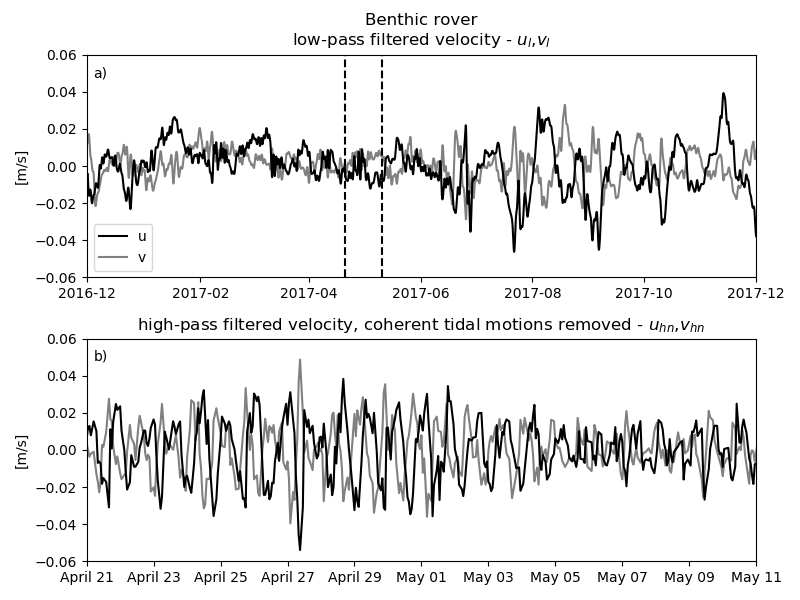

In [8]:
t1p = np.datetime64('2016-12-01')
t2p = np.datetime64('2017-12-01')

t1b = np.datetime64('2017-04-21')
t2b = np.datetime64('2017-05-11')

plt.figure(figsize=(8,6))
plt.subplot(211)
h1 = plt.plot(df_sub.index,df_sub['v_f'],'-',color='gray')
h2 = plt.plot(df_sub.index,df_sub['u_f'],'k-')
plt.ylim([-0.06,0.06])
plt.xlim([t1p,t2p])
yl = plt.ylim()
plt.plot([t1b,t1b],yl,'k--')
plt.plot([t2b,t2b],yl,'k--')
xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0]+0.01*np.diff(xl),yl[1]-0.1*np.diff(yl),'a)')
plt.ylabel('[m/s]')
plt.title('Benthic rover\nlow-pass filtered velocity - $u_{l}$,$v_{l}$')
plt.legend((h2[0],h1[0]),['u','v'],loc='lower left')

plt.subplot(212)
plt.plot(df_sub.index,df_sub['v_super'],color='gray')
plt.plot(df_sub.index,df_sub['u_super'],color='k')
plt.ylim([-0.06,0.06])
plt.xlim([t1b,t2b])
monthyearFmt = mdates.DateFormatter('%B %d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)
xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0]+0.01*np.diff(xl),yl[1]-0.1*np.diff(yl),'b)')
plt.ylabel('[m/s]')
plt.title('high-pass filtered velocity, coherent tidal motions removed - $u_{hn}$,$v_{hn}$')
plt.tight_layout()

plt.savefig('figures_paper/rover_tseries_examples.png',dpi=600)
plt.savefig('figures_paper/rover_tseries_examples.pdf')

### Spectral analysis

In [9]:
u = np.array(df_sub['u'])
v = np.array(df_sub['v'])

N = len(u)
window_width = N/3
fu,Su = welch(u,fs=24.,nperseg=window_width,window='hanning')
fv,Sv = welch(v,fs=24.,nperseg=window_width,window='hanning')

<IPython.core.display.Javascript object>


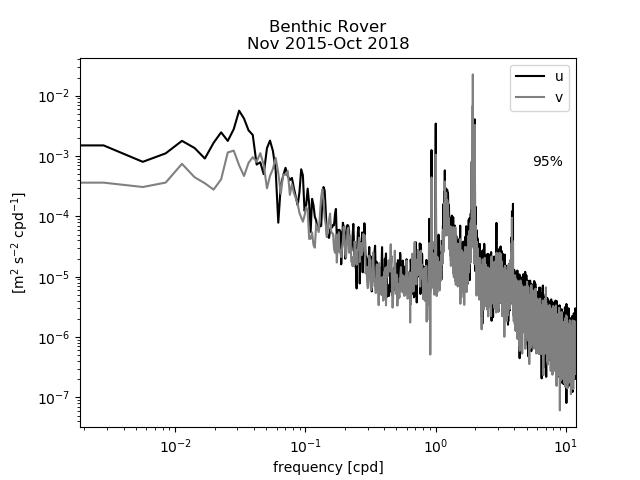

In [10]:
plt.figure()
plt.loglog(fu,Su,'k-')
plt.loglog(fv,Sv,'-',color='gray')
xl = plt.xlim()
plt.xlim(xl[0],np.max(fu))

# confidence intervals (Emery and Thomson)
dof = 2*window_width
edof = (8/3)*dof
lower = edof/chi2.ppf(0.975,edof)
upper = edof/chi2.ppf(0.025,edof)
fplot = 5
fac = 0.0008
plt.plot(np.array([fplot,fplot]),fac*np.array([lower,upper]),'k-')
plt.text(fplot+0.5,fac*np.mean([lower,upper]),'95%',verticalalignment='center')

plt.legend(['u','v'])
plt.xlabel('frequency [cpd]')
plt.ylabel('[m$^2$ s$^{-2}$ cpd$^{-1}$]')
plt.title('Benthic Rover\nNov 2015-Oct 2018')

plt.savefig('figures_paper/rover_spectrum.png')
plt.savefig('figures_paper/rover_spectrum.pdf')

### Descriptive statistics, 60-day means and standard deviations

In [11]:
df_all_2M = df_all_int.rolling(24*60,min_periods=24*60,center=True).mean()
df_all_2M_mon = df_all_2M.resample('1M').last()
df_all_2Mstd = df_all_int.rolling(24*60,min_periods=24*60,center=True).std()
df_all_2Mstd_mon = df_all_2Mstd.resample('1M').last()

<IPython.core.display.Javascript object>


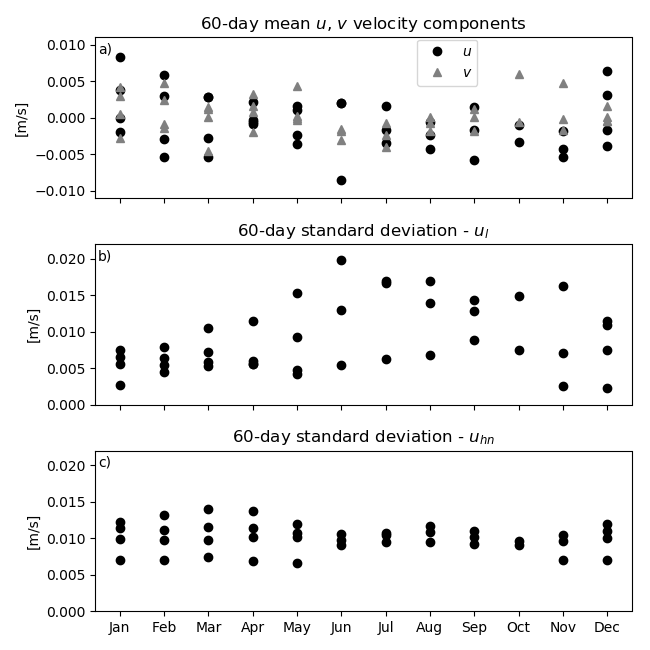

In [12]:
plt.figure(figsize=(6.5,6.5))
plt.subplot(311)
plt.plot(df_all_2M_mon.index.month,df_all_2M_mon['u_f'],'ko')
plt.plot(df_all_2M_mon.index.month,df_all_2M_mon['v_f'],'^',color='gray')
plt.ylim([-0.011,0.011])
plt.ylabel('[m/s]')
xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0]+0.005*np.diff(xl),yl[1]-0.1*np.diff(yl),'a)')
plt.gca().set_xticks(np.arange(1,13))
plt.gca().set_xticklabels([])
plt.legend(['$u$','$v$'],loc=(0.6,0.7))
plt.title('60-day mean $u$, $v$ velocity components')

plt.subplot(312)
plt.plot(df_all_2Mstd_mon.index.month,df_all_2Mstd_mon['u_f'],'ko')
plt.ylim([0,0.022])
plt.ylabel('[m/s]')
xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0]+0.005*np.diff(xl),yl[1]-0.1*np.diff(yl),'b)')
plt.gca().set_xticks(np.arange(1,13))
plt.gca().set_xticklabels([])
plt.title('60-day standard deviation - $u_{l}$')

plt.subplot(313)
plt.plot(df_all_2Mstd_mon.index.month,df_all_2Mstd_mon['u_super'],'ko')
plt.ylim([0,0.022])
plt.ylabel('[m/s]')
xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0]+0.005*np.diff(xl),yl[1]-0.1*np.diff(yl),'c)')
plt.gca().set_xticks(np.arange(1,13))
plt.gca().set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('60-day standard deviation - $u_{hn}$')
plt.tight_layout()

plt.savefig('figures_paper/monthly_stats.png',dpi=600)
plt.savefig('figures_paper/monthly_stats.pdf')

### Test for statistically significant differences between months

ANOVA with Tukey HSD post-hoc test to account for multiple comparisons.

In [13]:
fi = np.isfinite(df_all_2Mstd_mon['u_f'])

In [14]:
MultiComp = MultiComparison(df_all_2Mstd_mon['u_f'][fi],
                            df_all_2Mstd_mon.index.month[fi])

In [15]:
print(MultiComp.tukeyhsd(0.05).summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2     0.0005  -0.0106 0.0115 False 
  1      3     0.0016  -0.0095 0.0127 False 
  1      4     0.0016  -0.0095 0.0127 False 
  1      5     0.0028  -0.0083 0.0139 False 
  1      6     0.0072  -0.0048 0.0192 False 
  1      7     0.0077  -0.0042 0.0197 False 
  1      8     0.007    -0.005 0.019  False 
  1      9     0.0065  -0.0055 0.0184 False 
  1      10    0.0056  -0.0079 0.0192 False 
  1      11    0.0031  -0.0089 0.0151 False 
  1      12    0.0025  -0.0086 0.0136 False 
  2      3     0.0012  -0.0099 0.0122 False 
  2      4     0.0011   -0.01  0.0122 False 
  2      5     0.0023  -0.0087 0.0134 False 
  2      6     0.0067  -0.0052 0.0187 False 
  2      7     0.0073  -0.0047 0.0192 False 
  2      8     0.0065  -0.0054 0.0185 False 
  2      9     0.006    -0.006 0.018  False 
  2      10    0.0052  -0.0084 0.0188 False 
  2 

In [16]:
MultiComp_std = MultiComparison(df_all_2Mstd_mon['u_f'][fi],
                            df_all_2Mstd_mon.index.month[fi])

### 60-day running means and standard deviations

<IPython.core.display.Javascript object>


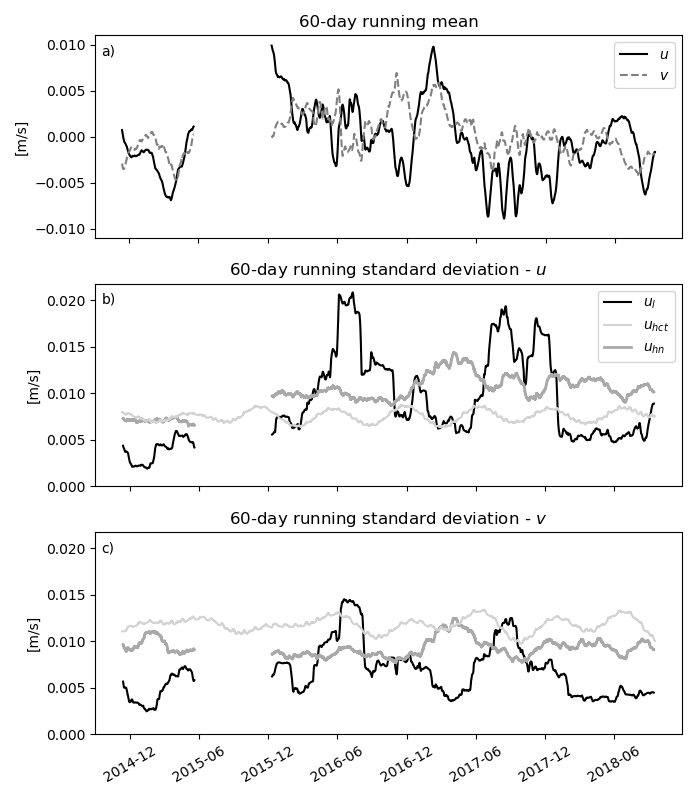

In [17]:
plt.figure(figsize=(7,8))
plt.subplot(311)
plt.plot(df_all_2M.index,df_all_2M['u_f'],'k-')
plt.plot(df_all_2M.index,df_all_2M['v_f'],'--',color='gray')
plt.title('60-day running mean')
plt.ylim([-0.011,0.011])
plt.ylabel('[m/s]')
plt.gca().set_xticklabels([])
yl = plt.ylim()
xl = plt.xlim()
plt.text(xl[0]+0.01*np.diff(xl),yl[1]-0.1*np.diff(yl),'a)')
plt.legend(['$u$','$v$'])

plt.subplot(312)
hl = plt.plot(df_all_2Mstd.index,df_all_2Mstd['u_f'],'k-')
hh = plt.plot(df_all_2Mstd.index,df_all_2Mstd['u_super'],'-',color='darkgray',lw=2)
ht = plt.plot(df_all_2Mstd.index,df_all_2Mstd['u_tide'],'-',color='lightgray')
plt.gca().set_xticklabels([])
yl = plt.ylim()
plt.ylim([0,yl[1]])
plt.ylabel('[m/s]')
plt.title('60-day running standard deviation - $u$')
yl = plt.ylim()
xl = plt.xlim()
plt.text(xl[0]+0.01*np.diff(xl),yl[1]-0.1*np.diff(yl),'b)')
plt.legend([hl[0],ht[0],hh[0]],['$u_{l}$','$u_{hct}$','$u_{hn}$'])

plt.subplot(313)
plt.plot(df_all_2Mstd.index,df_all_2Mstd['v_f'],'k-')
plt.plot(df_all_2Mstd.index,df_all_2Mstd['v_super'],'-',color='darkgray',lw=2)
plt.plot(df_all_2Mstd.index,df_all_2Mstd['v_tide'],'-',color='lightgray')
plt.xticks(rotation=30)
plt.ylim([0,yl[1]])
plt.title('60-day running standard deviation - $v$')
plt.ylabel('[m/s]')
plt.tight_layout()
yl = plt.ylim()
xl = plt.xlim()
plt.text(xl[0]+0.01*np.diff(xl),yl[1]-0.1*np.diff(yl),'c)')

plt.savefig('figures_paper/runnning_stats.png',dpi=600)
plt.savefig('figures_paper/runnning_stats.pdf')